In [1]:
## Keras for deep learning
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential

## Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#for logging
import time

##matrix math
import math

##plotting
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import talib
import pandas as pd
import os
import talib as ta
import time
import datetime

os.chdir('D:/Graduate Courses/2019 Dissertation/Data/Other.coins')
print("Current Working Directory " , os.getcwd())

Using TensorFlow backend.


Current Working Directory  D:\Graduate Courses\2019 Dissertation\Data\Other.coins


In [2]:
def load_data(filename,percent):
#Read the data file
    dataset_total = pd.read_csv(filename,na_values='n/a',parse_dates=['Date'],index_col='Date')
    dataset_total=dataset_total.drop(['Unnamed: 0',], axis=1)
    dataset_total= dataset_total.loc[:, (dataset_total!= 0).any(axis=0)]


    #normalize dataset
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range = (0, 1))
    dataset_total_scaled = sc.fit_transform(dataset_total)
    X_normal=dataset_total_scaled[:,:-1]
    Y=dataset_total_scaled[:,-1]
    
    #Splitting data set into training (First 80% of data points) and testing data (last 20% of data points)
    split_line = round(percent * X_normal.shape[0])
    X_train = X_normal[:int(split_line), :]
    Y_train = Y[:int(split_line)]
    X_test = X_normal[int(split_line):,:]
    Y_test = Y[int(split_line):]
    Y_daybefore = Y[int(split_line)-1:-1]

    #shuffle the training set and test set
    #X_train, X_test, Y_train, Y_test = train_test_split(X_normal, Y, test_size=0.2, random_state=37)
    return X_train, Y_train, X_test, Y_test, dataset_total,Y_daybefore


# In[2]:


def initialize_model(dropout_rate):
    """
    Initializes and creates the model to be used
    
    Arguments:
    dropout_rate -- A decimal representing how much dropout should be incorporated at each level, in this case 0.2
    activation_function -- A string to define the activation_function, in this case it is linear
    loss_function -- A string to define the loss function to be used, in the case it is mean squared error
    optimizer -- A string to define the optimizer to be used, in the case it is adam
    
    Returns:
    model -- A 3 layer RNN with 100*dropout_value dropout in each layer that uses activation_function as its activation
             function, loss_function as its loss function, and optimizer as its optimizer
    """
  
    #Build the model
    model=Sequential()
    
   
    optimizer='adam'
    loss='mean_squared_error'
    activation='relu'
    input_shape = (X_train.shape[1],)
    model.add(Dense(units = 64,activation=activation, input_shape = input_shape))
    model.add(Dense(units = 64, activation=activation))
    model.add(Dense(units = 32, activation=activation))
    model.add(Dense(units = 1,activation='relu'))
   
    
              
    model.compile(optimizer =optimizer, loss = loss, metrics=['mse'])

    
    return model


# In[3]:


#Training the model

def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    """
    Fits the model to the training data
    
    Arguments:
    model -- The previously initalized 3 layer Recurrent Neural Network
    X_train -- A tensor of shape (2492, 30, 105) that represents the x values of the training data
    Y_train -- A tensor of shape (2492,) that represents the y values of the training data
    batch_num -- An integer representing the batch size to be used, in this case 100
    num_epoch -- An integer defining the number of epochs to be run, in this case 100
    val_split -- A decimal representing the proportion of training data to be used as validation data
    
    Returns:
    model -- The 3 layer Recurrent Neural Network that has been fitted to the training data
    training_time -- An integer representing the amount of time (in seconds) that the model was training
    """
   

    #Train the model on X_train and Y_train
    history=model.fit(X_train, Y_train, batch_size= batch_num, nb_epoch=num_epoch, validation_split= val_split)

    return model,history


# test the model
def test_model(model_name, X_test, Y_test):
    """
    Test the model on the testing data
    
    Arguments:
    model -- The previously fitted 3 layer Recurrent Neural Network
    X_test -- A tensor of shape (623, 30, 105) that represents the x values of the testing data
    Y_test -- A tensor of shape (623,) that represents the y values of the testing data
    unnormalized_bases -- A tensor of shape (623,) that can be used to get unnormalized data points
    
    Returns:
    y_predict -- A tensor of shape (623,) that represnts the normalized values that the model predicts based on X_test
    real_y_test -- A tensor of shape (623,) that represents the actual prices of bitcoin throughout the testing period
    real_y_predict -- A tensor of shape (623,) that represents the model's predicted prices of bitcoin
    fig -- A branch of the graph of the real predicted prices of bitcoin versus the real prices of bitcoin
    """
    #Test the model on X_Test
    Y_norm = model_name.predict(X_test)
    
    # normalize predicted y
    Y_original=dataset_total.iloc[:,-1]
    Y_max=Y_original.max()
    Y_min=Y_original.min()
    real_y_predict = Y_norm *(Y_max-Y_min)+Y_min
    
    # normalize Y_test
    real_y_test = Y_test *(Y_max-Y_min)+Y_min
    
    # normalize real Y_daybefore
    real_y_daybefore = Y_daybefore * (Y_max-Y_min)+Y_min

    #Plot of the predicted prices versus the real prices
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title("Bitcoin Return Over Time")
    plt.plot(real_y_predict, color = 'green', label = 'Predicted Return')
    plt.plot(real_y_test, color = 'red', label = 'Real Return')
    ax.set_ylabel("Return")
    ax.set_xlabel("Time (Days)")
    ax.legend()
    
    return Y_norm, real_y_test, real_y_predict, fig, real_y_daybefore



#evaluate change in return

def return_change(real_y_daybefore, real_y_test, real_y_predict):
    """
    Calculate the percent change between each value and the day before
    
    Arguments:
    real_y_daybefore -- A tensor of shape (623,) that represents the prices of each day before each price in Y_test
    Y_test -- A tensor of shape (623,) that represents the normalized y values of the testing data
    y_predict -- A tensor of shape (623,) that represents the normalized y values of the model's predictions
    
    Returns:
    delta_predict -- A tensor of shape (623, ) that represents the difference between predicted and day before values
    delta_real -- A tensor of shape (623, ) that represents the difference between real and day before values
    fig -- A plot representing percent change in bitcoin price per day,
    """
    return_change_real = real_y_test - real_y_daybefore
    real_y_predict_reshape= np.reshape(real_y_predict,(real_y_predict.shape[0],))
    return_change_predict = real_y_predict_reshape - real_y_daybefore

    fig_2 = plt.figure(figsize=(10, 6))
    ax = fig_2.add_subplot(111)
    ax.set_title("Change in Bitcoin Return Per Day")
    plt.plot(return_change_predict, color='green', label = 'Predicted Return Change')
    plt.plot(return_change_real, color='red', label = 'Real Return Change')
    plt.ylabel("Return Change")
    plt.xlabel("Time (Days)")
    ax.legend()
    plt.show()
    return  return_change_predict, return_change_real, fig_2


# In[8]:


def binary_return(return_change_predict,return_change_real):
    """
    Converts return change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change
    
    Arguments:
    delta_predict -- A tensor of shape (623, 1) that represents the predicted percent change in price
    delta_real -- A tensor of shape (623, 1) that represents the real percent change in price
    
    Returns:
    delta_predict_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_real
    """
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    return_change_predict_1_0 = np.empty(return_change_predict.shape)
    return_change_real_1_0 = np.empty(return_change_real.shape)

    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(return_change_predict.shape[0]):
        if return_change_predict[i] > 0:
            return_change_predict_1_0[i] = 1
        else:
            return_change_predict_1_0[i] = 0
  
    for i in range(return_change_real.shape[0]):
        if  return_change_real[i] > 0:
            return_change_real_1_0[i] = 1
        else:
            return_change_real_1_0[i] = 0
    return return_change_predict_1_0, return_change_real_1_0



# In[6]:


def find_positives_negatives(return_change_predict_1_0, return_change_real_1_0):
    """
    Finding the number of false positives, false negatives, true positives, true negatives
    
    Arguments: 
    delta_predict_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_real
    
    Returns:
    true_pos -- An integer that represents the number of true positives achieved by the model
    false_pos -- An integer that represents the number of false positives achieved by the model
    true_neg -- An integer that represents the number of true negatives achieved by the model
    false_neg -- An integer that represents the number of false negatives achieved by the model
    """
    #Finding the number of false positive/negatives and true positives/negatives
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(return_change_real_1_0.shape[0]):
        real = return_change_real_1_0[i]
        predicted = return_change_predict_1_0[i]
        if real == 1:
            if predicted == 1:
                true_pos += 1
            else:
                false_neg += 1
        elif real == 0:
            if predicted == 0:
                true_neg += 1
            else:
                false_pos += 1
    return true_pos, false_pos, true_neg, false_neg

(426, 98)
(426,)
(180, 98)
(180,)
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 12,609
Trainable params: 12,609
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 340 samples, validate on 86 samples
Epoch 1/100
340/340 [==============================] - 0s 1ms/step - loss: 0.0380 - mean_squared_error: 0.0380 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 2/100
340/340 [==============================] - 0s 46us/step - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 3/100
340/340 [==============================] - 0s 46us/step - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 4/100
340/340 [==============================] - 0s 46us/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 5/100
340/340 [==============================] - 0s 46us/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 6/100
340/340 [==============================] - 0s 0us/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0071 - val_

Epoch 100/100
340/340 [==============================] - 0s 92us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0108 - val_mean_squared_error: 0.0108


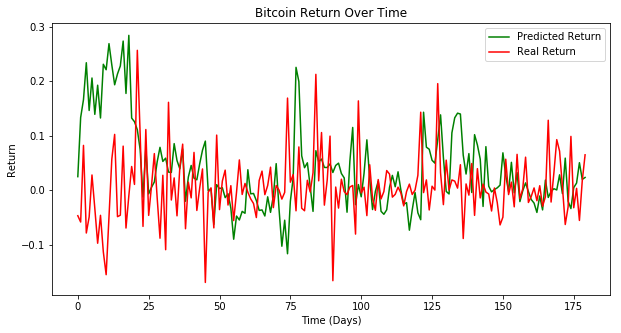

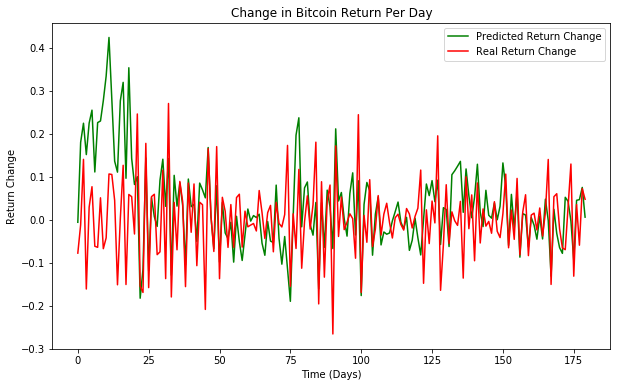

true positive is 74
true negative is 47
false negative is 20
false positive is 39
precision rate is 0.6549
accuracy rate is 0.6722
recall rate is 0.7872
F1 Score is 0.715


In [3]:
coin_names=['merge_EOS-USD.csv','merge_ETH-USD.csv','merge_LTC-USD.csv','merge_ZEC-USD.csv','merge_XRP-USD.csv']
#EOS
#Load the data
X_train, Y_train, X_test, Y_test, dataset_total,Y_daybefore = load_data(coin_names[0],0.7035)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)

#initialize the model
model= initialize_model(0.2)
print (model.summary())

#fit the model
model,history = fit_model(model, X_train, Y_train, 32, 100, .2)
#test the model
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#plot the return change per day
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)

#calculate confusion matrix statistics
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)
print('false positive is',false_pos)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(1118, 110)
(1118,)
(180, 110)
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                7104      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 13,377
Trainable params: 13,377
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 894 samples, validate on 224 samples
Epoch 1/100
894/894 [==============================] - 1s 680us/step - loss: 0.0568 - mean_squared_error: 0.0568 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 2/100
894/894 [==============================] - 0s 52us/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 3/100
894/894 [==============================] - 0s 52us/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 4/100
894/894 [==============================] - 0s 37us/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 5/100
894/894 [==============================] - 0s 57us/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 6/100
894/894 [==============================] - 0s 35us/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0053 - 

Epoch 100/100
894/894 [==============================] - 0s 85us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0121 - val_mean_squared_error: 0.0121


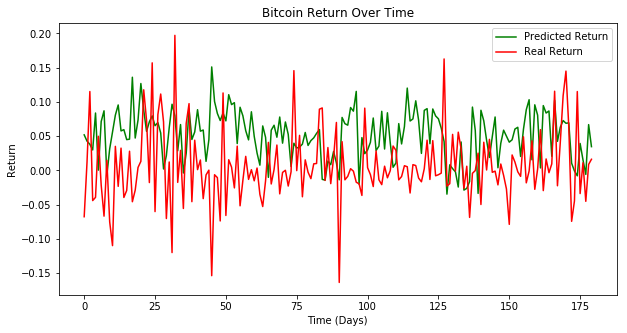

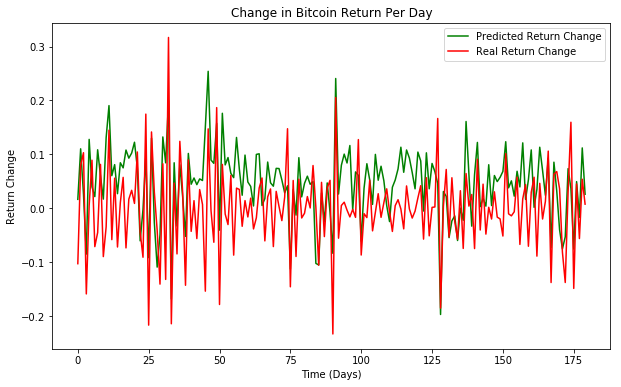

true positive is 89
true negative is 29
false negative is 6
false positive is 56
precision rate is 0.6138
accuracy rate is 0.6556
recall rate is 0.9368
F1 Score is 0.7417


In [4]:
coin_names=['merge_EOS-USD.csv','merge_ETH-USD.csv','merge_LTC-USD.csv','merge_ZEC-USD.csv','merge_XRP-USD.csv']
#ETH
#Load the data
X_train, Y_train, X_test, Y_test, dataset_total,Y_daybefore = load_data(coin_names[1],0.8614)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)

#initialize the model
model= initialize_model(0.2)
print (model.summary())

#fit the model
model,history = fit_model(model, X_train, Y_train, 32, 100, .2)
#test the model
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#plot the return change per day
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)

#calculate confusion matrix statistics
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)
print('false positive is',false_pos)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(1770, 108)
(1770,)
(180, 108)
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                6976      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 13,249
Trainable params: 13,249
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1416 samples, validate on 354 samples
Epoch 1/100
1416/1416 [==============================] - 1s 625us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 2/100
1416/1416 [==============================] - 0s 58us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 3/100
1416/1416 [==============================] - 0s 55us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 4/100
1416/1416 [==============================] - 0s 55us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 5/100
1416/1416 [==============================] - 0s 44us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 6/100
1416/1416 [==============================] - 0s 44us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_lo

Epoch 49/100
1416/1416 [==============================] - 0s 40us/step - loss: 7.3076e-04 - mean_squared_error: 7.3076e-04 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 50/100
1416/1416 [==============================] - 0s 37us/step - loss: 7.5630e-04 - mean_squared_error: 7.5630e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 51/100
1416/1416 [==============================] - 0s 35us/step - loss: 8.5868e-04 - mean_squared_error: 8.5868e-04 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 52/100
1416/1416 [==============================] - 0s 39us/step - loss: 7.3551e-04 - mean_squared_error: 7.3551e-04 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 53/100
1416/1416 [==============================] - 0s 37us/step - loss: 7.0216e-04 - mean_squared_error: 7.0216e-04 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 54/100
1416/1416 [==============================] - 0s 37us/step - loss: 7.4337e-04 - mean_squared_error: 7.4337e-04 - 

Epoch 96/100
1416/1416 [==============================] - 0s 38us/step - loss: 6.1282e-04 - mean_squared_error: 6.1282e-04 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 97/100
1416/1416 [==============================] - 0s 39us/step - loss: 5.2045e-04 - mean_squared_error: 5.2045e-04 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 98/100
1416/1416 [==============================] - 0s 37us/step - loss: 5.8698e-04 - mean_squared_error: 5.8698e-04 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 99/100
1416/1416 [==============================] - 0s 35us/step - loss: 6.5783e-04 - mean_squared_error: 6.5783e-04 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 100/100
1416/1416 [==============================] - 0s 34us/step - loss: 6.3100e-04 - mean_squared_error: 6.3100e-04 - val_loss: 0.0175 - val_mean_squared_error: 0.0175


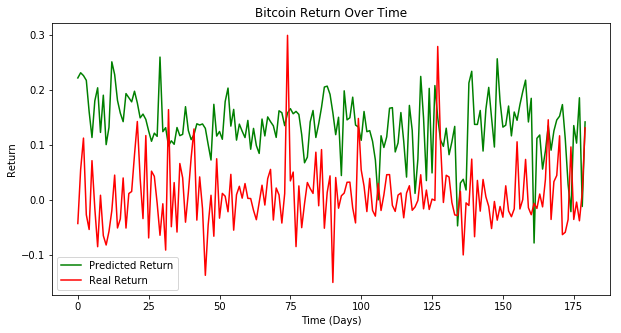

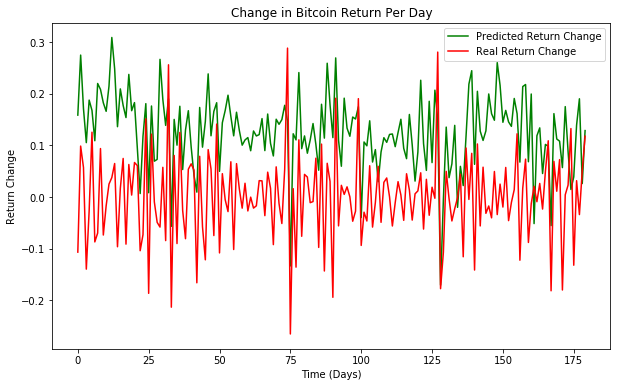

true positive is 92
true negative is 7
false negative is 1
false positive is 80
precision rate is 0.5349
accuracy rate is 0.55
recall rate is 0.9892
F1 Score is 0.6943


In [5]:
coin_names=['merge_EOS-USD.csv','merge_ETH-USD.csv','merge_LTC-USD.csv','merge_ZEC-USD.csv','merge_XRP-USD.csv']
#LTC
#Load the data
X_train, Y_train, X_test, Y_test, dataset_total,Y_daybefore = load_data(coin_names[2],0.9077)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)

#initialize the model
model= initialize_model(0.2)
print (model.summary())

#fit the model
model,history = fit_model(model, X_train, Y_train, 32, 100, .2)
#test the model
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#plot the return change per day
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)

#calculate confusion matrix statistics
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)
print('false positive is',false_pos)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(670, 112)
(670,)
(180, 112)
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                7232      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 13,505
Trainable params: 13,505
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 536 samples, validate on 134 samples
Epoch 1/100
536/536 [==============================] - 0s 855us/step - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 2/100
536/536 [==============================] - 0s 29us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 3/100
536/536 [==============================] - 0s 58us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 4/100
536/536 [==============================] - 0s 29us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 5/100
536/536 [==============================] - 0s 60us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 6/100
536/536 [==============================] - 0s 29us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0043 - 

Epoch 100/100
536/536 [==============================] - 0s 58us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0081 - val_mean_squared_error: 0.0081


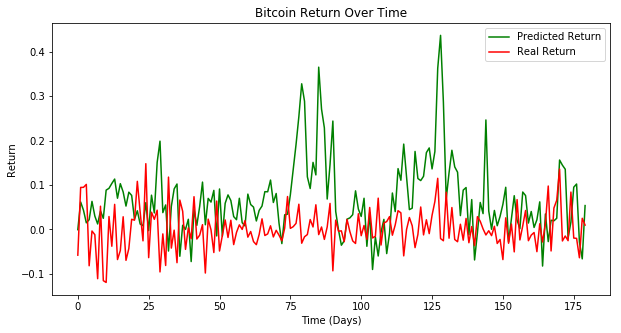

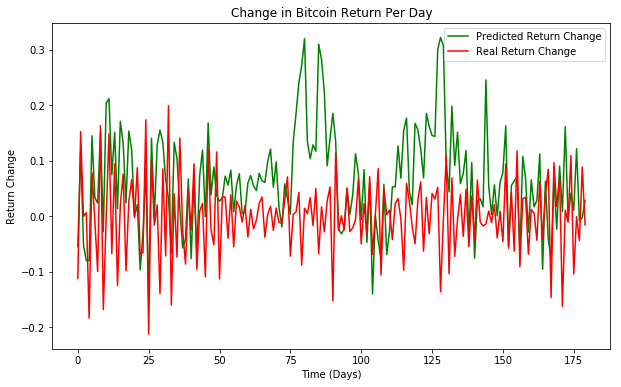

true positive is 86
true negative is 29
false negative is 9
false positive is 56
precision rate is 0.6056
accuracy rate is 0.6389
recall rate is 0.9053
F1 Score is 0.7257


In [6]:
coin_names=['merge_EOS-USD.csv','merge_ETH-USD.csv','merge_LTC-USD.csv','merge_ZEC-USD.csv','merge_XRP-USD.csv']
#ZEC
#Load the data
X_train, Y_train, X_test, Y_test, dataset_total,Y_daybefore = load_data(coin_names[3],0.7885)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)

#initialize the model
model= initialize_model(0.2)
print (model.summary())

#fit the model
model,history = fit_model(model, X_train, Y_train, 32, 100, .2)
#test the model
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#plot the return change per day
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)

#calculate confusion matrix statistics
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)
print('false positive is',false_pos)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(1316, 110)
(1316,)
(180, 110)
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                7104      
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 13,377
Trainable params: 13,377
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1052 samples, validate on 264 samples
Epoch 1/100
1052/1052 [==============================] - 1s 1ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 2/100
1052/1052 [==============================] - 0s 59us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3/100
1052/1052 [==============================] - 0s 74us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 4/100
1052/1052 [==============================] - 0s 59us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 5/100
1052/1052 [==============================] - 0s 59us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 6/100
1052/1052 [==============================] - 0s 59us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss

Epoch 50/100
1052/1052 [==============================] - 0s 74us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 51/100
1052/1052 [==============================] - 0s 91us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 52/100
1052/1052 [==============================] - 0s 74us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 53/100
1052/1052 [==============================] - 0s 104us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 54/100
1052/1052 [==============================] - 0s 105us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 55/100
1052/1052 [==============================] - 0s 83us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0012 - val_mean_squared_error: 0.0

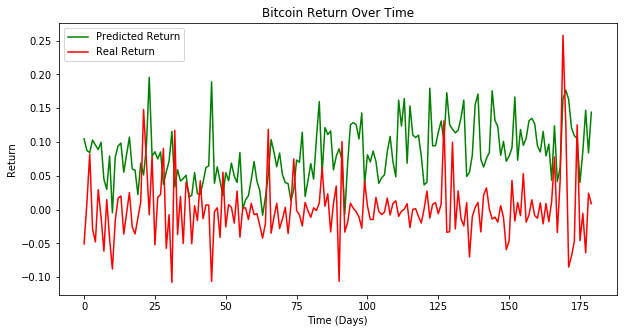

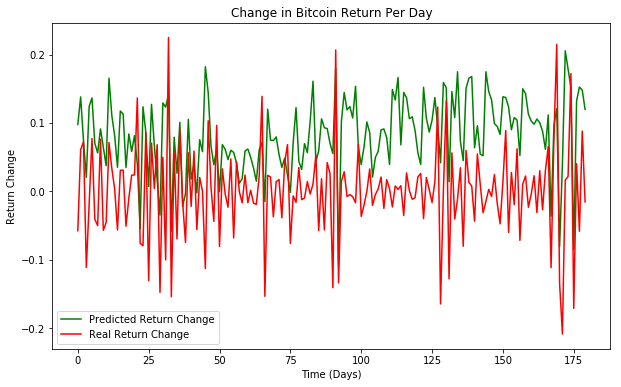

true positive is 95
true negative is 13
false negative is 0
false positive is 72
precision rate is 0.5689
accuracy rate is 0.6
recall rate is 1.0
F1 Score is 0.7252


In [7]:
coin_names=['merge_EOS-USD.csv','merge_ETH-USD.csv','merge_LTC-USD.csv','merge_ZEC-USD.csv','merge_XRP-USD.csv']
#XRP
#Load the data
X_train, Y_train, X_test, Y_test, dataset_total,Y_daybefore = load_data(coin_names[4],0.8798)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)

#initialize the model
model= initialize_model(0.2)
print (model.summary())

#fit the model
model,history = fit_model(model, X_train, Y_train, 32, 100, .2)
#test the model
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#plot the return change per day
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)

#calculate confusion matrix statistics
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)
print('false positive is',false_pos)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(2964, 73)
(2964,)
(180, 73)
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 64)                4736      
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 11,009
Trainable params: 11,009
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2371 samples, validate on 593 samples
Epoch 1/100
2371/2371 [==============================] - 1s 225us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 2/100
2371/2371 [==============================] - 0s 38us/step - loss: 6.8933e-04 - mean_squared_error: 6.8933e-04 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 3/100
2371/2371 [==============================] - 0s 39us/step - loss: 6.3250e-04 - mean_squared_error: 6.3250e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 4/100
2371/2371 [==============================] - 0s 40us/step - loss: 5.9190e-04 - mean_squared_error: 5.9190e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/100
2371/2371 [==============================] - 0s 35us/step - loss: 6.2701e-04 - mean_squared_error: 6.2701e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 6/100
2371/2371 [==============================] - 0s 38us/step - loss: 5.8223e-04 -

2371/2371 [==============================] - 0s 31us/step - loss: 3.1904e-04 - mean_squared_error: 3.1904e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 47/100
2371/2371 [==============================] - 0s 31us/step - loss: 4.5178e-04 - mean_squared_error: 4.5178e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 48/100
2371/2371 [==============================] - 0s 30us/step - loss: 3.7216e-04 - mean_squared_error: 3.7216e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 49/100
2371/2371 [==============================] - 0s 32us/step - loss: 3.8783e-04 - mean_squared_error: 3.8783e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 50/100
2371/2371 [==============================] - 0s 30us/step - loss: 3.1328e-04 - mean_squared_error: 3.1328e-04 - val_loss: 9.7017e-04 - val_mean_squared_error: 9.7017e-04
Epoch 51/100
2371/2371 [==============================] - 0s 31us/step - loss: 3.1728e-04 - mean_squared_error: 3.1728e-04 - val_l

2371/2371 [==============================] - 0s 36us/step - loss: 2.1601e-04 - mean_squared_error: 2.1601e-04 - val_loss: 3.7983e-04 - val_mean_squared_error: 3.7983e-04
Epoch 92/100
2371/2371 [==============================] - 0s 37us/step - loss: 2.0904e-04 - mean_squared_error: 2.0904e-04 - val_loss: 4.2067e-04 - val_mean_squared_error: 4.2067e-04
Epoch 93/100
2371/2371 [==============================] - 0s 34us/step - loss: 2.0138e-04 - mean_squared_error: 2.0138e-04 - val_loss: 3.7443e-04 - val_mean_squared_error: 3.7443e-04
Epoch 94/100
2371/2371 [==============================] - 0s 35us/step - loss: 2.0119e-04 - mean_squared_error: 2.0119e-04 - val_loss: 4.9128e-04 - val_mean_squared_error: 4.9128e-04
Epoch 95/100
2371/2371 [==============================] - 0s 35us/step - loss: 2.0596e-04 - mean_squared_error: 2.0596e-04 - val_loss: 4.1257e-04 - val_mean_squared_error: 4.1257e-04
Epoch 96/100
2371/2371 [==============================] - 0s 36us/step - loss: 2.0260e-04 - mean_s

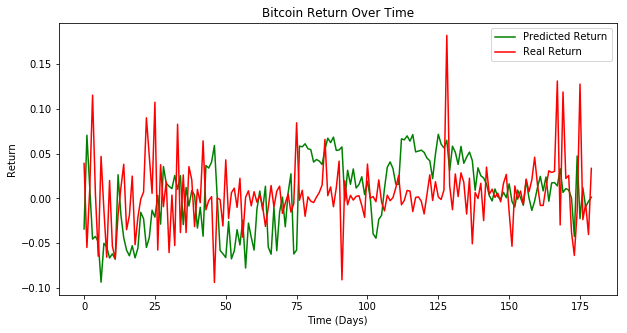

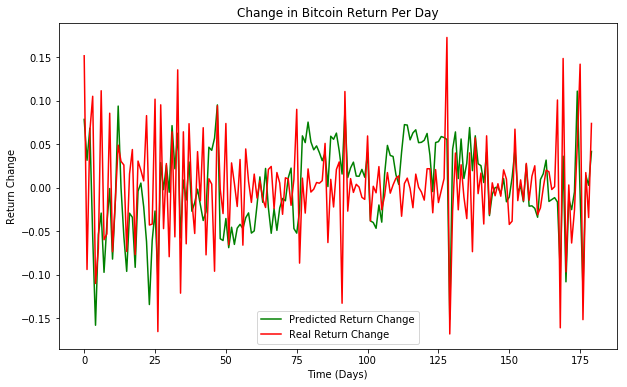

true positive is 58
true negative is 48
false negative is 38
false positive is 36
precision rate is 0.617
accuracy rate is 0.5889
recall rate is 0.6042
F1 Score is 0.6105


In [10]:
#Bitcoin
#Load the data
X_train, Y_train, X_test, Y_test, dataset_total,Y_daybefore = load_data('Bitcoin_revised.csv',0.9428)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)

#initialize the model
model= initialize_model(0.2)
print (model.summary())

#fit the model
model,history = fit_model(model, X_train, Y_train, 32, 100, .2)
#test the model
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#plot the return change per day
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)

#calculate confusion matrix statistics
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)
print('false positive is',false_pos)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))